In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import glob
import numpy as np
from fastai.vision import *
from fastai.layers import *
from fastai.metrics import*
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
pd.set_option('display.max_columns', 500)
import math

In [3]:
class ArcMarginProduct(nn.Module):
  """Implementation of the Arc Margin Product to be suitable for CelebA and VGGFace2.
    CelebA: multi-label classification -> One hot Encoded label
    VGGFace2: Label classification
    Args:
            in_features: size of each input sample (Output of the last layer from the pretrained model)
            out_features: size of each output sample (Number of classes)
            s: norm of input feature (Refer to the paper)
            m: margin (Refer to the paper)
            cos(theta + m)"""
  def __init__(self, in_features, out_features ,s=30.0, m=0.50, easy_margin=False):
    super(ArcMarginProduct,self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(out_features, in_features))
    nn.init.xavier_uniform_(self.weight)
    
  def forward(self,input):
    cosine = F.linear(F.normalize(input), F.normalize(self.weight))
    return cosine

In [4]:
class Customhead():
    """Implementation of the custom head for different model (Resnet34, Resnet50)
    Args:
        num_classes: Number of classes (CelebA: 40, VGGFace2: 9131)
        label: label of the dataset
        p_dropout: drop out ratio
        eps
        momentum
        affine
        track_running_stat
        """
    def __init__(self, num_classes, dataset, p_dropout=0.5, eps=1e-05, momentum=0.1,affine=True, track_running_stats=True):
        super(Customhead, self).__init__()
        self.num_classes = num_classes
        self.p_dropout = p_dropout
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stat = track_running_stats
        self.dataset = dataset
        
    def head(self):
        custom_head = nn.Sequential(
        AdaptiveConcatPool2d(1),
        Flatten(),
        nn.BatchNorm1d(4096, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=4096, out_features=512, bias=True),
        relu(inplace=True),
        nn.BatchNorm1d(512, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=512, out_features=512, bias=True),
        ArcMarginProduct(in_features=512,out_features=self.num_classes))
        return custom_head

In [5]:
class ArcfaceLoss(nn.Module):
  """Loss function for Arcface"""
  def __init__(self,s=30.0, m=0.5, dataset='vggface2', loss_type = 'focalloss',easy_margin = False):
    super(ArcfaceLoss,self).__init__()
    self.s = s
    self.m = m
    self.dataset = dataset
    self.easy_margin = easy_margin
    self.cos_m = math.cos(m)
    self.sin_m = math.sin(m)
    self.th = math.cos(math.pi - m)
    self.mm = math.sin(math.pi - m) * m
    self.loss_type = loss_type
    self.cross_loss = nn.CrossEntropyLoss()
    self.gamma = 1
    self.eps = 1e-7
    
  def forward(self,input,label):
    cosine = input
    sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
    phi = cosine * self.cos_m - sine * self.sin_m
    if self.easy_margin:
      phi = torch.where(cosine > 0, phi, cosine)
    else:
      phi = torch.where(cosine > self.th, phi, cosine - self.mm)
    if self.dataset == 'celeba':
      one_hot = self.label
    elif self.dataset == 'vggface2':
      one_hot = torch.zeros(cosine.size(), device='cuda')
      one_hot.scatter_(1,label.view(-1, 1).long(), 1)
    else:
      raise ValueError('Select the dataset - CelebA or VGGFace2')
    output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
    output *= self.s
    
    if self.loss_type == 'focalloss':
      logp = self.cross_loss(output,label)
      p = torch.exp(-logp)
      loss = (1 - p) ** self.gamma * logp
      loss_out = loss.mean()
    else:
      loss_out = self.cross_loss(output,label)
    
    return loss_out

In [6]:
path = 'data/data-fellow-ai/VGGFace2-100/data/train_100'

In [7]:
fnames = get_image_files(path, recurse=True)
fnames[-5:]

[PosixPath('data/data-fellow-ai/VGGFace2-100/data/train_100/n009170/0190_01.jpg'),
 PosixPath('data/data-fellow-ai/VGGFace2-100/data/train_100/n009170/0069_01.jpg'),
 PosixPath('data/data-fellow-ai/VGGFace2-100/data/train_100/n009170/0194_01.jpg'),
 PosixPath('data/data-fellow-ai/VGGFace2-100/data/train_100/n009170/0119_01.jpg'),
 PosixPath('data/data-fellow-ai/VGGFace2-100/data/train_100/n009170/0291_01.jpg')]

In [8]:
# data = ImageDataBunch.from_folder(path,valid_pst=0.2, bs=64, ds_tfms= get_transforms(),size=224)

In [9]:
pat = '.+\/.+\/(.+)\/.+.jpg'
bs = 64

In [10]:
data = ImageDataBunch.from_name_re(path, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

In [ ]:
data.show_batch(rows=4, figsize=(10,8))

In [11]:
arch = models.resnet50

In [12]:
arc_face_head = Customhead(num_classes = 100,dataset='vggface2')

In [13]:
custom_loss_func = ArcfaceLoss() 

In [14]:
learn = cnn_learner(data, arch,custom_head=arc_face_head.head(), metrics=[accuracy])

In [15]:
learn.loss_func=custom_loss_func

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


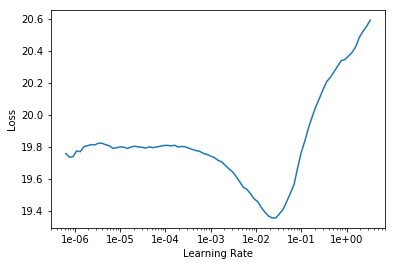

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1,slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,12.895855,10.680252,0.671338,04:52


In [ ]:
learn.fit_one_cycle(4, slice(1e-2/2))

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


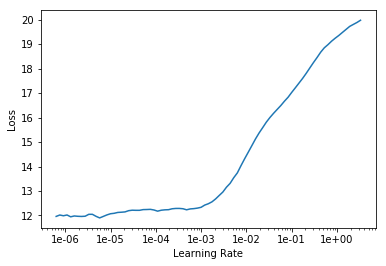

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1,slice(1e-3/2))

epoch,train_loss,valid_loss,accuracy,time
0,8.984907,7.179396,0.797060,06:17


In [ ]:
learn.fit_one_cycle(5,slice(1e-3/2))

epoch,train_loss,valid_loss,accuracy,time
